In [4]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dir_path = "./images"

# 

i = 0


for fn in os.listdir(dir_path):
#     print(fn)
    
    dir_i = dir_path + "/" + fn + "/"
    filenames = tf.constant([dir_i + fn1 for fn1 in os.listdir(dir_i)])
    
#     print(filenames)
    
    if i==0 :
        filenames_all = tf.constant(filenames)   
        labels = tf.zeros(filenames.shape, dtype=tf.int32)
    else:
        filenames_all = tf.concat([filenames_all, filenames], axis=-1)
        labels_i = tf.fill(filenames.shape, i)
        labels = tf.concat([labels, labels_i], axis=-1)
        
    i = i + 1
    
dataset = tf.data.Dataset.from_tensor_slices((filenames_all, labels))

In [3]:
# 取数据查看
sub_dataset = dataset.take(3)

for x,y in sub_dataset:
    print(x.numpy())
    print(y.numpy())

b'./images/n02085620-Chihuahua/n02085620_10074.jpg'
0
b'./images/n02085620-Chihuahua/n02085620_10131.jpg'
0
b'./images/n02085620-Chihuahua/n02085620_10621.jpg'
0


In [4]:
def decode_image_and_resize(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_resized = tf.image.resize(image_decoded, [224,224]) / 255.0
    return image_resized, label

In [5]:
# dataset = dataset.map(map_func=decode_image_and_resize,
#                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(map_func=decode_image_and_resize,
                     num_parallel_calls=4)

In [ ]:
# 查看获取图片效果
sub_dataset = dataset.take(-1)

for x,y in sub_dataset:
    print(x.shape)
    print(y.numpy())

In [ ]:
for x,y in sub_dataset:
    print(x.numpy())

In [ ]:
# sub_dataset
# dataset
buffer_size

In [6]:
buffer_size = tf.size(labels)
buffer_size = tf.cast(buffer_size, dtype=tf.int64)
# labels.shape
# buffer_size
dataset = dataset.shuffle(buffer_size)

In [7]:
sub_dataset = dataset.take(10000)

# for x,y in sub_dataset:
#     plt.title(y.numpy())
#     plt.imshow(x.numpy())
#     plt.show()

In [8]:
batch_size = 10
sub_dataset = sub_dataset.batch(batch_size)
sub_dataset = sub_dataset.prefetch(tf.data.experimental.AUTOTUNE)
# dataset = dataset.batch(batch_size)
# dataset = dataset.prefetch(-1)

In [ ]:
it = iter(dataset)
images, labels_t = next(it)

In [ ]:
images.shape
# it

In [ ]:
labels_t.shape

In [5]:
def vgg16_model(input_shape=(224, 224, 3)):
    vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                       weights='imagenet',
                                       input_shape=input_shape)
    
    for layer in vgg16.layers:
        layer.trainable = False
        
    last = vgg16.output
    
    # 加入全连接层
    x = tf.keras.layers.Flatten()(last)
    
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dropout(0.3)(x)
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dropout(0.3)(x)
    #输出层
    x = tf.keras.layers.Dense(120, activation='softmax')(x)
    
    #模型建立
    model = tf.keras.models.Model(inputs=vgg16.input, outputs=x)
    
    model.summary()
    
    return model

In [6]:
model = vgg16_model()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
training_epochs = 5
# sub_dataset
sub_dataset

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [12]:
model.fit(sub_dataset, epochs=training_epochs, verbose=1)

Train for 1000 steps
Epoch 1/5
1000/1000 [==============================] - 2442s 2s/step - loss: 7.9320 - accuracy: 0.1075
Epoch 2/5
1000/1000 [==============================] - 6838s 7s/step - loss: 5.1614 - accuracy: 0.3687
Epoch 3/5
1000/1000 [==============================] - 7238s 7s/step - loss: 3.8407 - accuracy: 0.5036
Epoch 4/5
1000/1000 [==============================] - 7836s 8s/step - loss: 3.1410 - accuracy: 0.5794
Epoch 5/5
1000/1000 [==============================] - 8387s 8s/step - loss: 2.6776 - accuracy: 0.6375


In [17]:
test_dataset = dataset.skip(10000)

In [20]:
batch_size = 10
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
# 保存模型
test_loss, test_acc = model.evaluate(test_dataset, verbose = 1)
model_filename = 'models/dogsCNNModel1-' + "%.6f-"%(test_loss) + "%.6f"%(test_acc) +'.h5'
model.save_weights(model_filename)
print("save ok!")

1058/1058 [==============================] - 4740s 4s/step - loss: 1.7712 - accuracy: 0.7340
save ok!


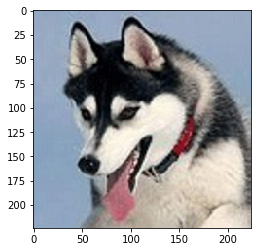

(1, 224, 224, 3)


In [23]:
from PIL import Image
# 加载图片
img = Image.open("dog1.jpg")

img_r = img.resize((224, 224))
img_data = np.array(img_r)
img_data2 = np.array([img_data])

plt.imshow(img_data)
plt.show()

print(img_data2.shape)

In [25]:
# 进行预测
preds = model.predict(img_data2)

In [26]:
preds

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [38]:
i = tf.argmax(preds, 1).numpy()[0]

In [35]:
f_l = [fn2 for fn2 in os.listdir(dir_path)]

In [39]:
f_l[i]

'n02110185-Siberian_husky'

In [7]:
#模型结构保存
yaml_string = model.to_yaml()
with open('./models/dogs.yaml', 'w') as model_file:
    model_file.write(yaml_string)
    